# Visualize COCO features

1. visualize coco features
2. identify pca-one; what is its cosine similarity with the residual (should be very high)
3. move along the direction, plot 1-dim loss landscape. [-2,-1,-0.5,0,0.5,1,2]
    - need to have a fn(scalar,), output loss. 


In [7]:
import argparse
import os
import random
import shutil
import time
import warnings
from enum import Enum
import pickle
import numpy as np
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn

import glob 
def my_norm(x):
    return x/np.linalg.norm(x, axis=-1, keepdims=True)

In [8]:
data_dict_list = list()

for pickle_path in glob.glob('./features*/feature_dump_*.pkl'):
    with open(pickle_path, 'rb') as pkl_file:
        data_dict = pickle.load(pkl_file)
        assert len(data_dict['clip_image_features_list']) == len(data_dict['clip_text_features_list'])
        # assert len(data_dict['clip_image_features_list']) == len(data_dict['target_image_features_list'])
        # print('Number of image-text pairs', len(data_dict['clip_image_features_list']))
        data_dict_list.append(data_dict)

print('Number of experiment files loaded', len(data_dict_list))

Number of experiment files loaded 25


In [9]:
# visualize.

# from sklearn.decomposition import PCA
# from sklearn.decomposition import TruncatedSVD as PCA # showns as multiple lines. 
# from sklearn.manifold import TSNE as PCA # 
# import umap
from umap import UMAP as PCA
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set(font_scale=2)  # crazy big
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set_theme()


In [10]:
# Functionality: given a list of exp, plot one modality. 
sns.set_context("talk", font_scale=1.5) # paper, notebook, talk, and poster; font_scale=1.5,

def plot_scattered_cones(data_dict_list, modality_str, draw=True):
    assert modality_str in ['clip_image_features_list', 'clip_text_features_list', 'target_image_features_list']
    print('modality_str: ', modality_str)
    # dataset_size = len(data_dict_list[0][modality_str])
    dataset_size = 5000

    total_feature_list = list()
    label_list = list()
    for expriment_idx in range(len(data_dict_list)):
        total_feature_list.append(data_dict_list[expriment_idx][modality_str][:dataset_size])
        label_list.extend(['Random-{}'.format(expriment_idx+1)] * dataset_size)
    total_feature_np = np.concatenate(total_feature_list, axis=0) 
    total_feature_np = my_norm(total_feature_np) # L2-normalize
    assert len(total_feature_np) == len(data_dict_list) * dataset_size

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(total_feature_np)

    df = pd.DataFrame()
    df['pca_one'] = pca_result[:,0]
    df['pca_two'] = pca_result[:,1] 
    df['Random Seed'] = label_list

    if draw:
        plt.figure(figsize=(20.0,6.18 * 2))
        p1 = sns.scatterplot(
            x="pca_one", y="pca_two",
            hue="Random Seed",
            data=df,
            legend=True,
        )
        plt.xlabel("")
        plt.ylabel("")
        plt.legend(title='Random Seed', loc='upper left', bbox_to_anchor=(1.00, 1.0, ), prop={'size': 18})
        plt.show()

    return df


modality_str:  clip_image_features_list


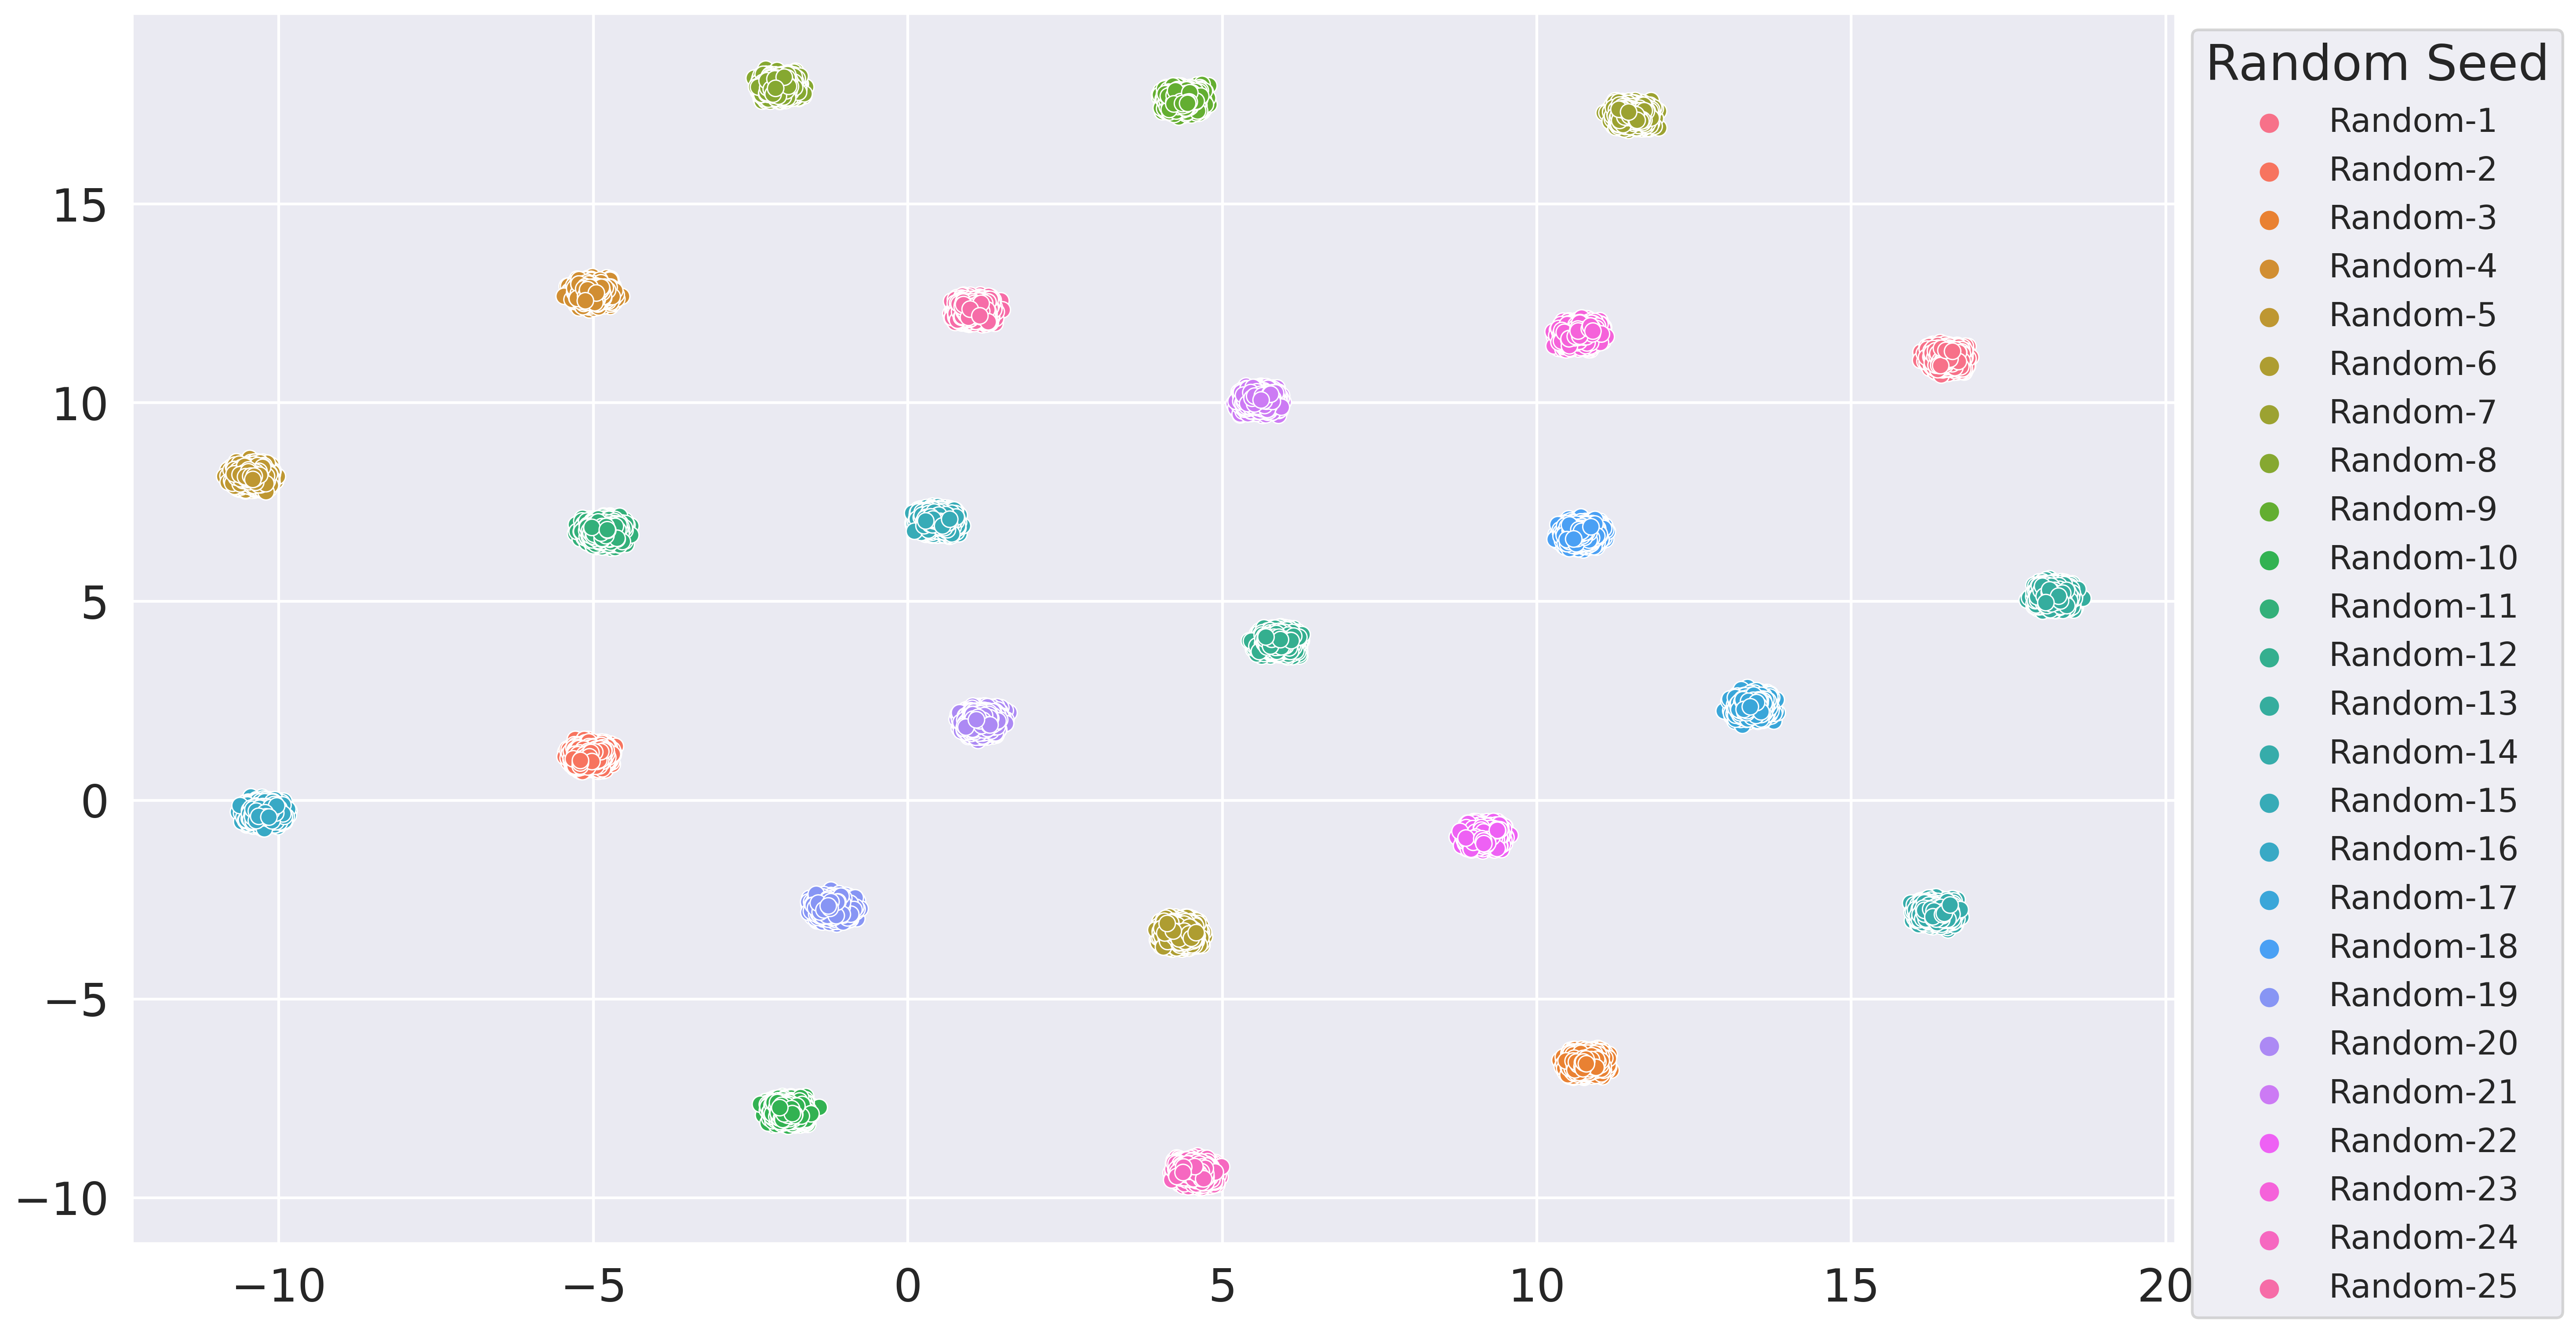

modality_str:  clip_text_features_list


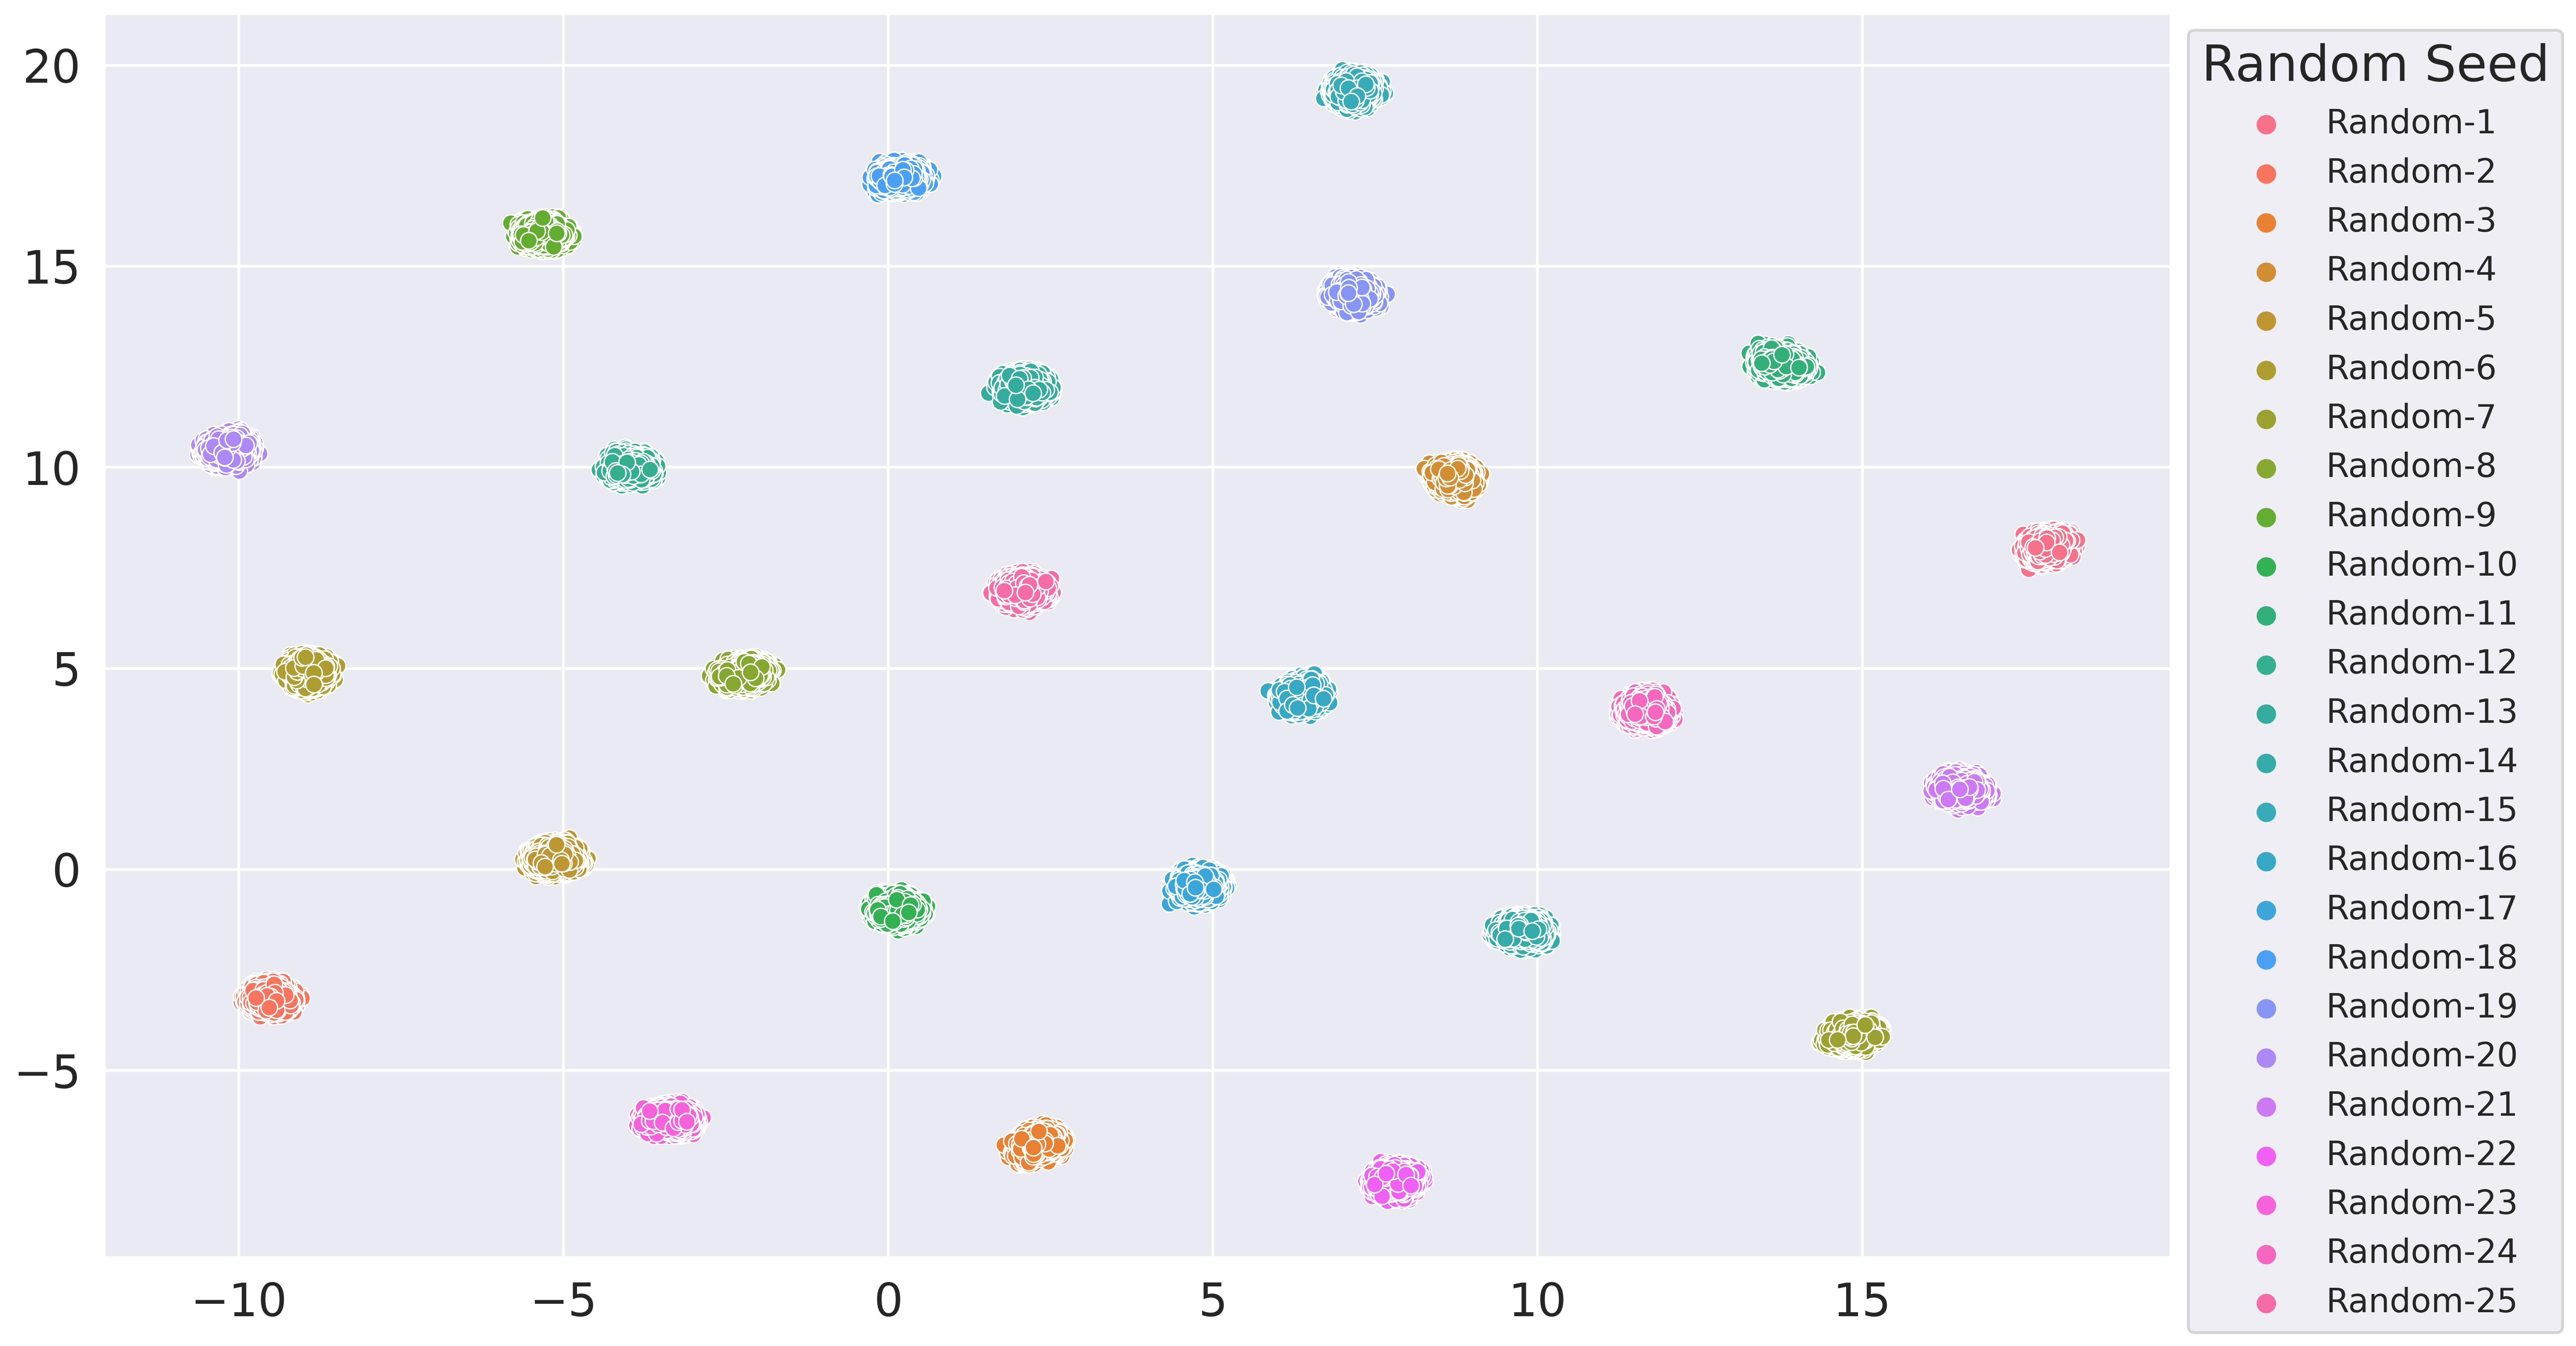

modality_str:  target_image_features_list


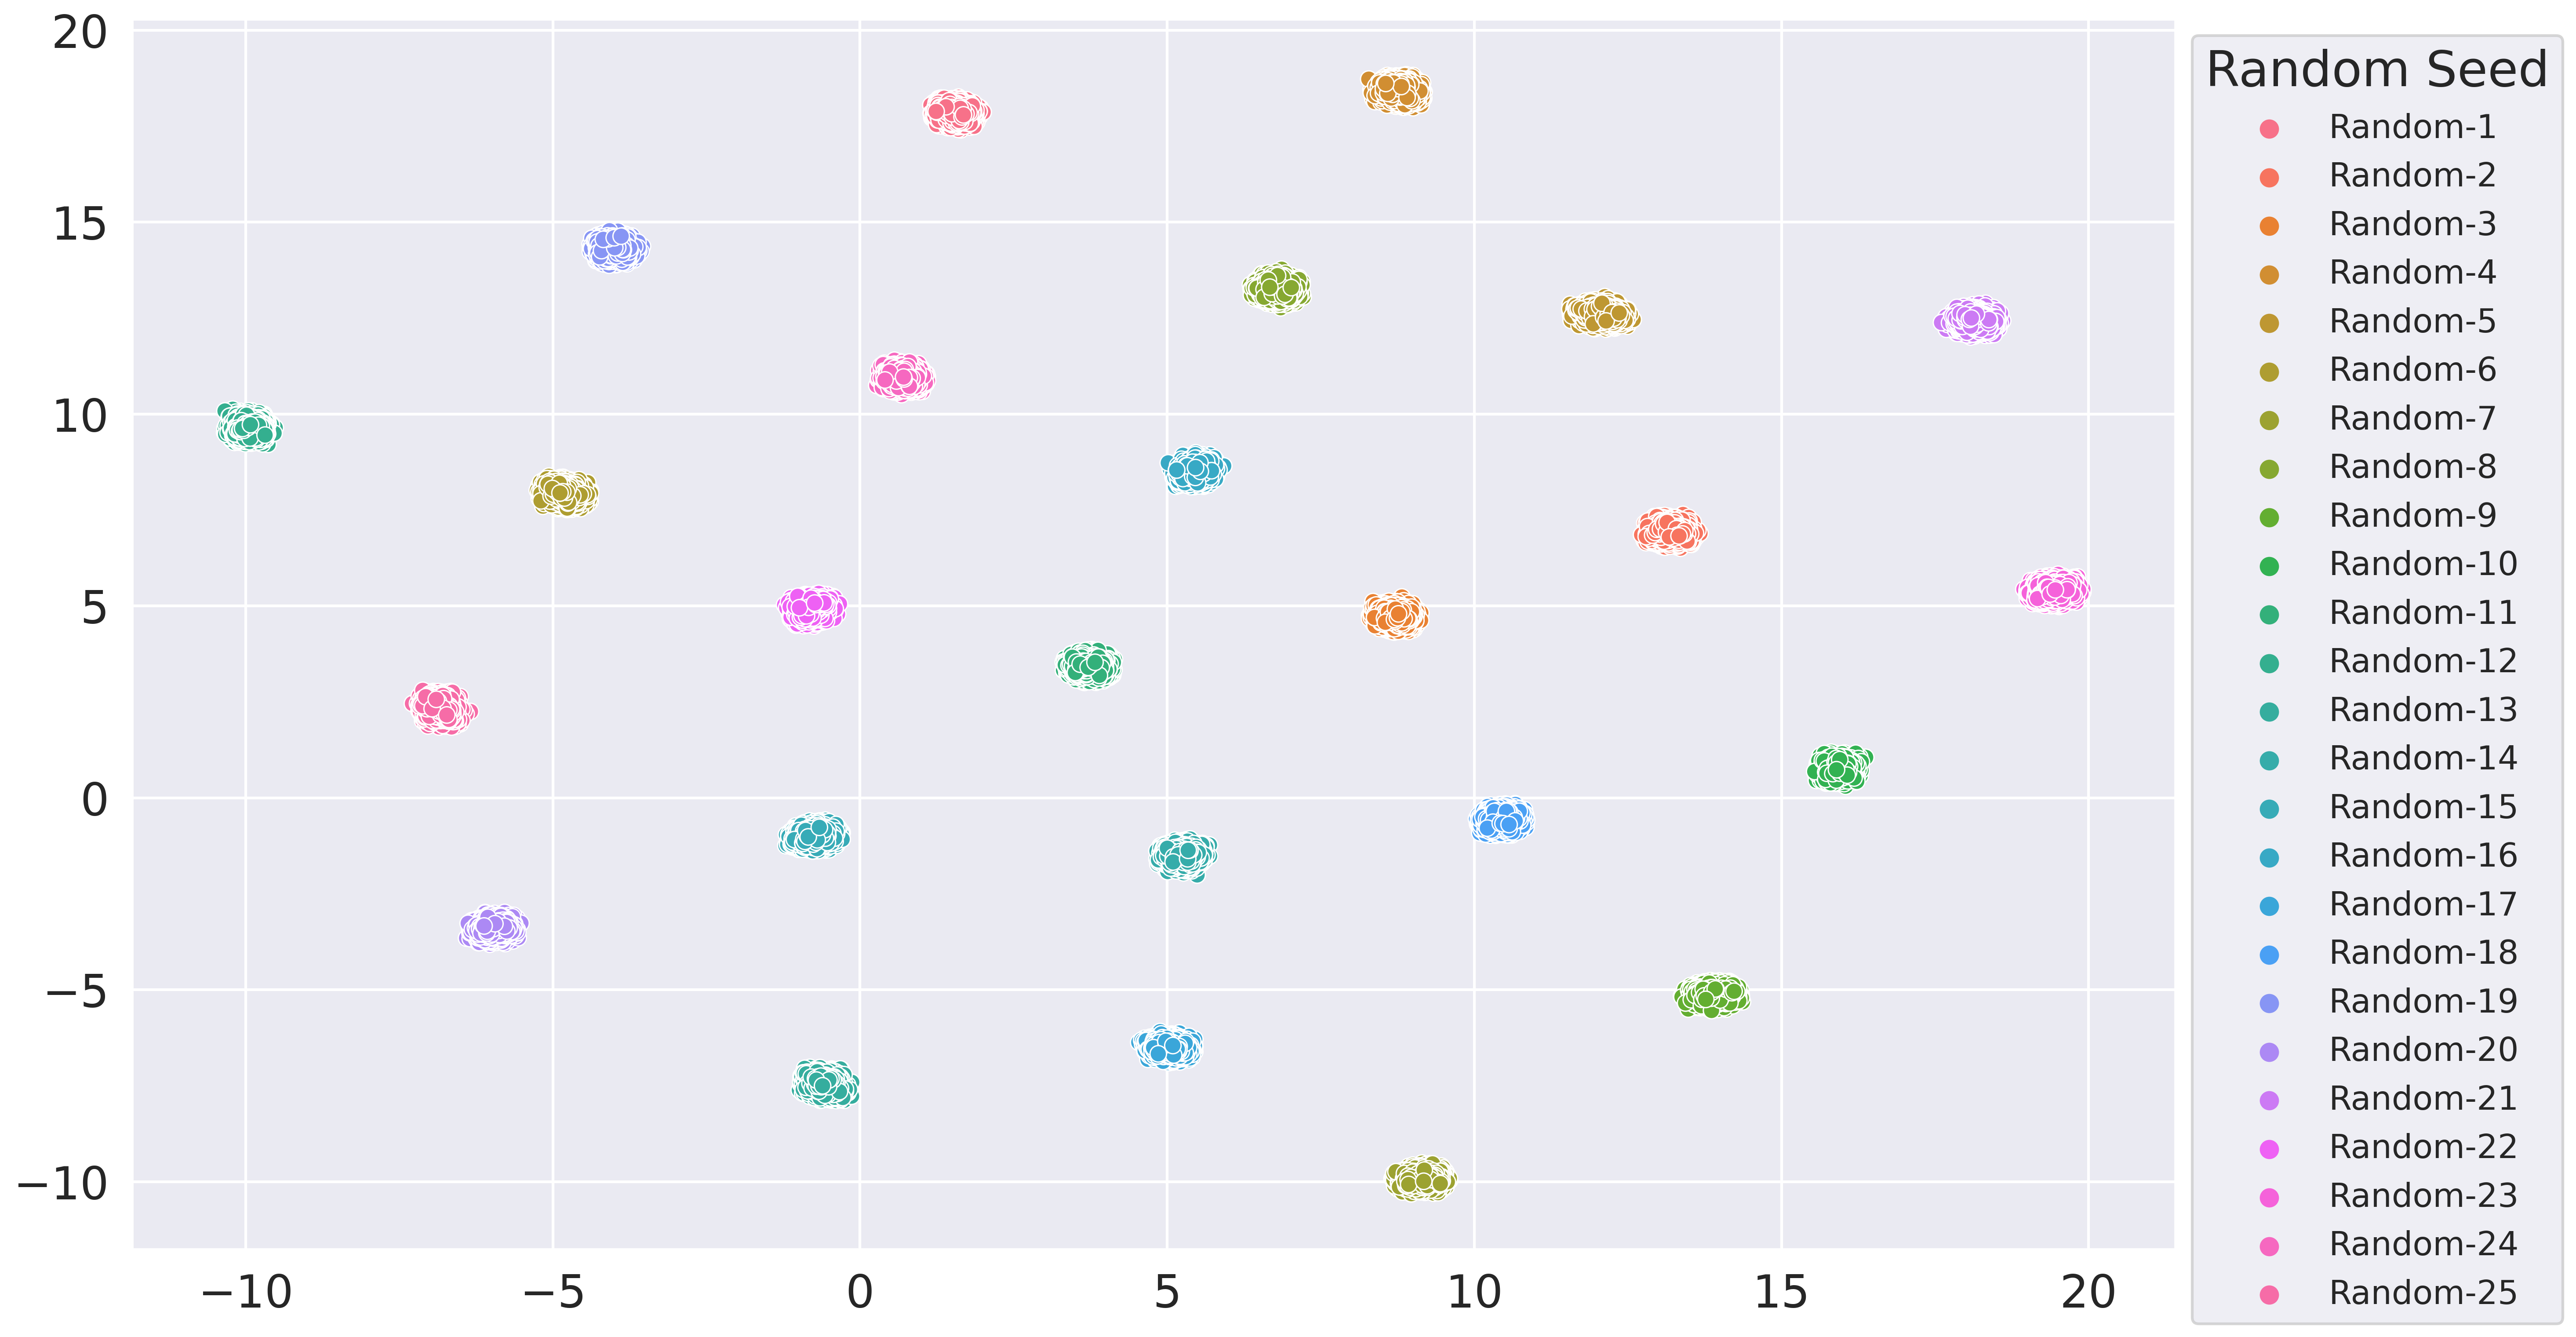

In [11]:
df_clip_img = plot_scattered_cones(data_dict_list[:25], 'clip_image_features_list',   draw=True)
df_clip_txt = plot_scattered_cones(data_dict_list[:25], 'clip_text_features_list',    draw=True)
df_resnet   = plot_scattered_cones(data_dict_list[:25], 'target_image_features_list', draw=True)


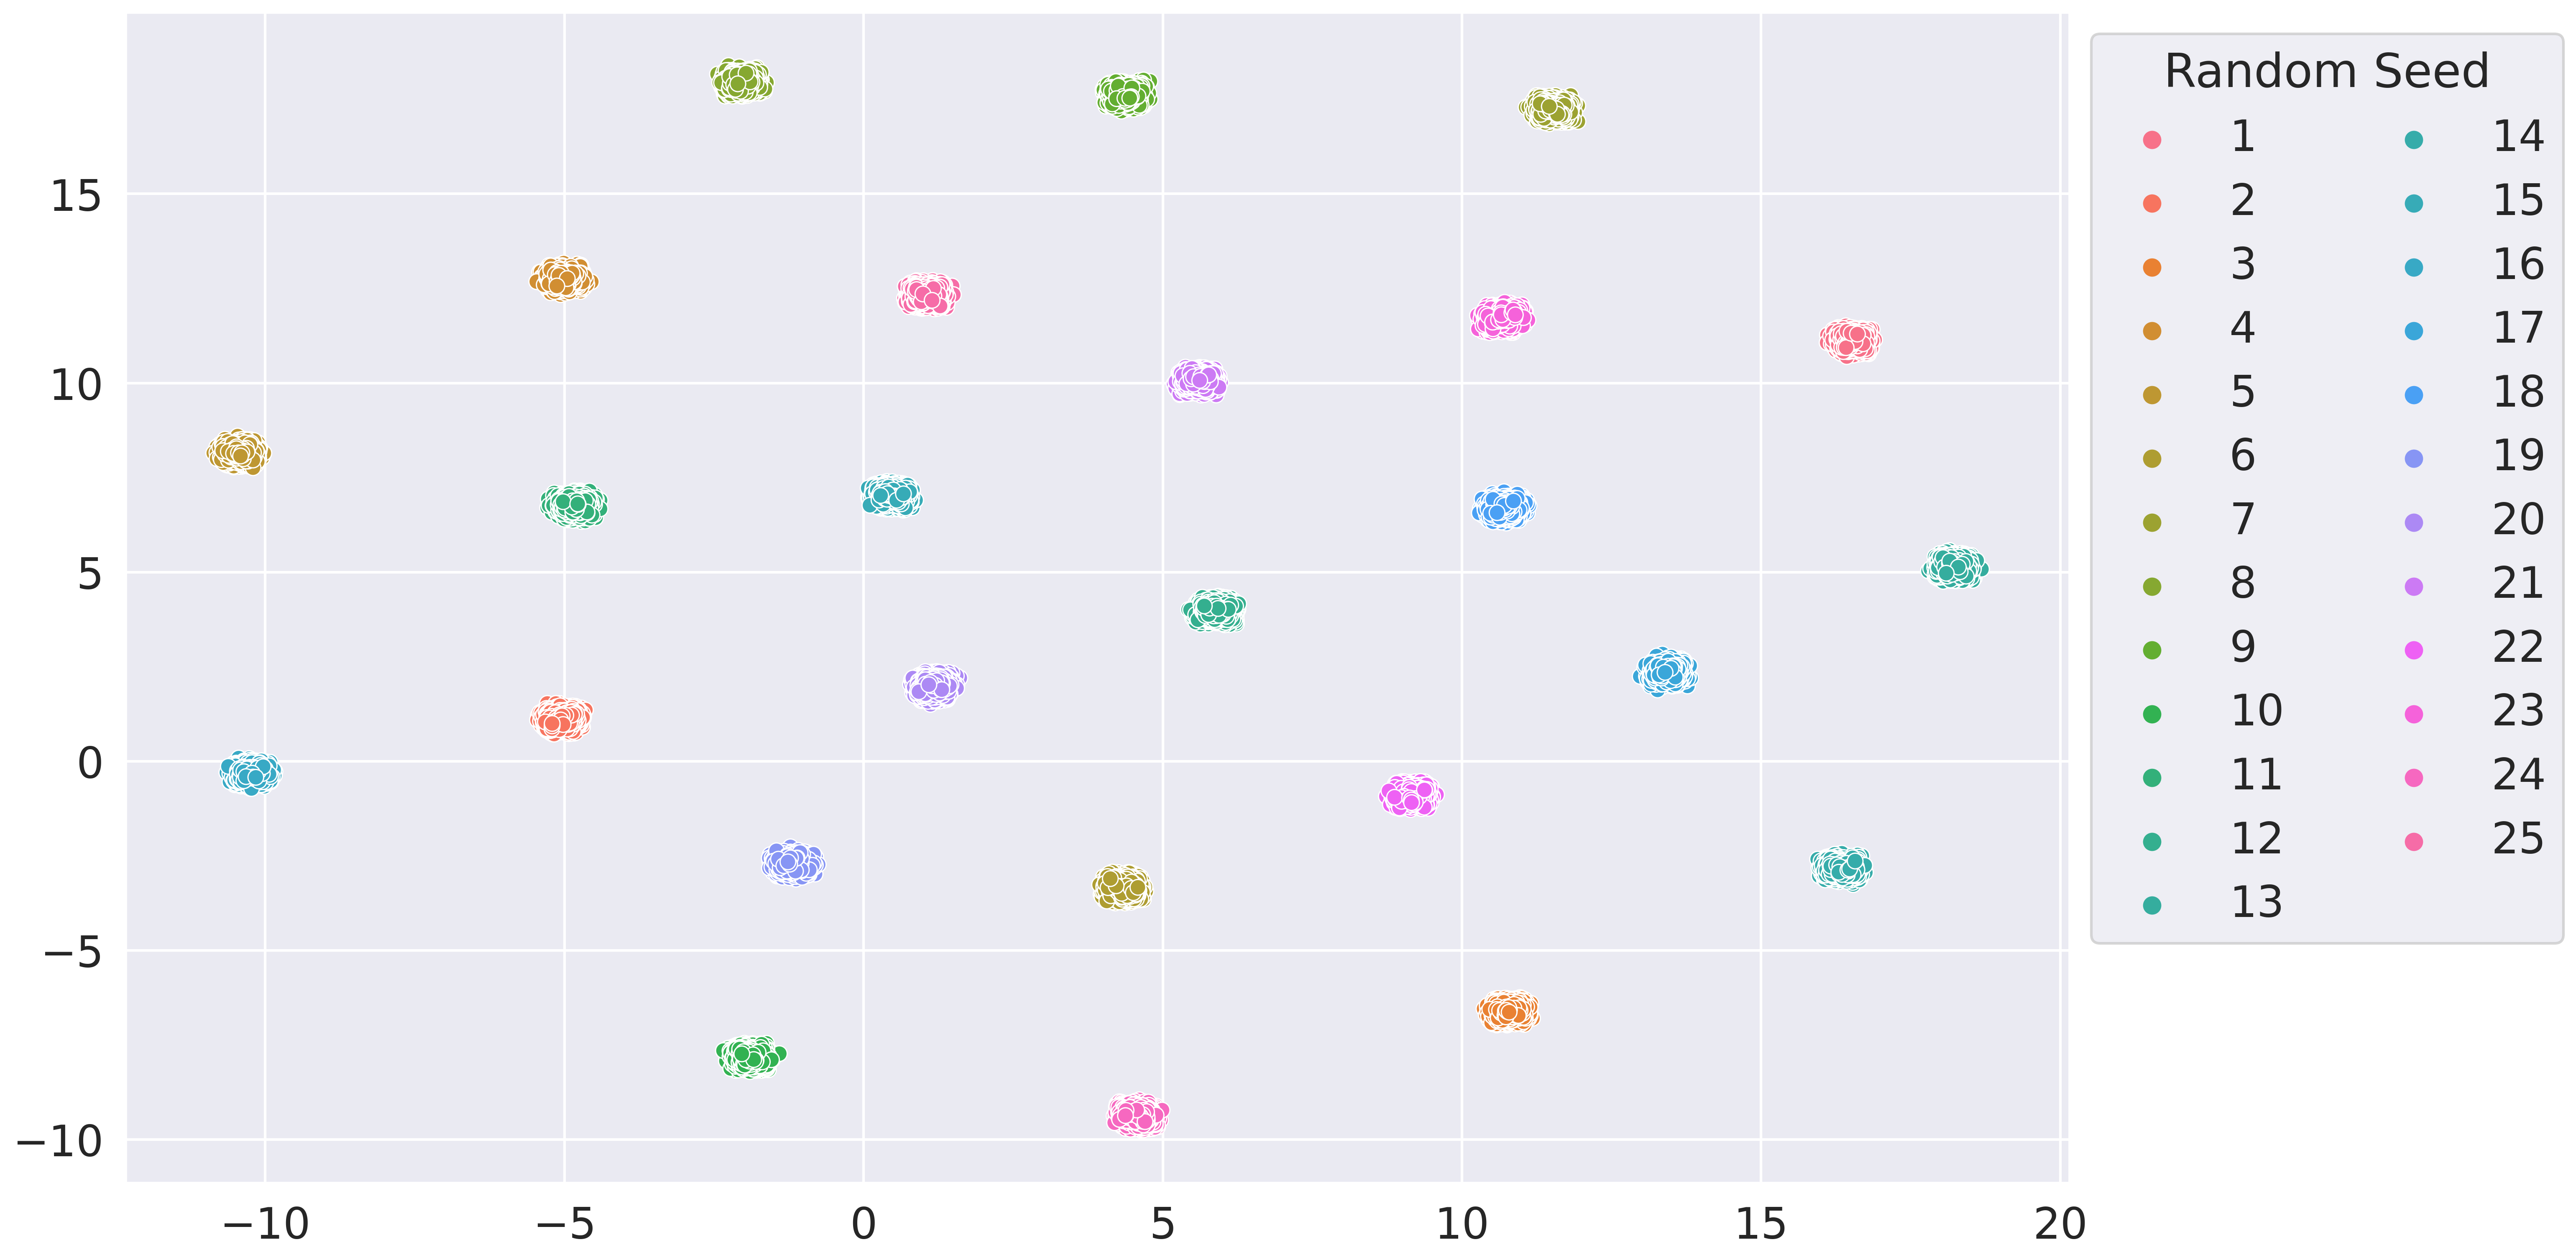

In [12]:
def draw_df(df):
    plt.figure(figsize=(20.0,6.18 * 2))
    df['Seed'] = df['Random Seed'].str.replace('Random-', '', regex=False)
    p1 = sns.scatterplot(
        x="pca_one", y="pca_two",
        hue="Seed",
        data=df,
        legend=True,
    )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend(title='Random Seed', loc='upper left', bbox_to_anchor=(1.00, 1.0, ), ncol=2) # prop={'size': 50}, 
    plt.show()
    return

draw_df(df_clip_img)